Python ile Bayesci Çıkarım (Bayesian Inference)
===============================================

## Sürekli çıktılara sahip İki Deney Grubunun Karşılaştırılması

<p>Deney, insanların zeka seviyesini artırdığını iddia eden bir ilacın etkinliğini ölçmeyi amaçlamaktadır. Tedavi grubunda 47 denek, kontrol grubunda 42 denek yer almaktadır. </p>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f08f2e1e128>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f08f041f4a8>], dtype=object)

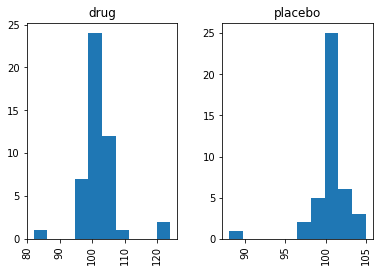

In [1]:
import pandas as pd
%matplotlib inline

drug = pd.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pd.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))

trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group')

<p>Örnekler aykırı noktalar (**outlier**) içerdiğinden, deneklerin IQ skorlarının dağılımlarını açıklamak için Student-t dağılımını kullanacağız. T dağılımı, Normal dağılıma göre aykırı noktalara daha az hassasdır.</p>
<p>Üç parametreli Student-t dağılımı ortalama $\mu $, kesinlik (ters-varyans) $\lambda $ ve serbestlik derecesi $\nu$ tanımlamıza imkan sağlar:</p>

$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}.$$
<p>Burada serbestlik derecesi, verinin normalliğini belirtir. Büyük $\nu $ değerleri, dağılımın normal dağılıma yakınsamasını sağlar. </p>
<p>O halde likelihood fonksiyonlarımızı aşağıdaki gibi tanımlayalım:</p>

$$\begin{align}
y^{(drug)}_i &\sim T(\nu, \mu_1, \sigma_1) \\
y^{(placebo)}_i &\sim T(\nu, \mu_2, \sigma_2)
\end{align}$$

<p>Kolaylık olması için serbestlik derecesini her iki grup için de aynı aldık.</p>

## Önsel Seçim

<p>Ortalamalar gerçel değerlerdir ve bunları normal dağılımla belirleyeceğiz. IQ skorlarının ortalaması 100 olduğundan ve skorların normal dağıldığını bildiğimizden:</p>

$$\mu_k \sim N(100, 10^2)$$

<p>seçelim. </p>

In [2]:
from pymc3 import Model, Normal

with Model() as drug_model:
  
  μ_0 = Normal('μ_0', 100, sd=10)
  μ_1 = Normal('μ_1', 100, sd=10)

<p>Standart sapmalar için de düzgün dağılımı kullanacağız:</p>

In [3]:
from pymc3 import Uniform

with drug_model:
  
  σ_0 = Uniform('σ_0', lower=0, upper=20)
  σ_1 = Uniform('σ_1', lower=0, upper=20)

<p>Serbestlik derecesi $\nu $ için, ortalaması 30 olan üstel dağılım kullanacağız. </p>

In [4]:
from pymc3 import Exponential

with drug_model:
  ν = Exponential('ν_minus_one', 1/29.) + 1

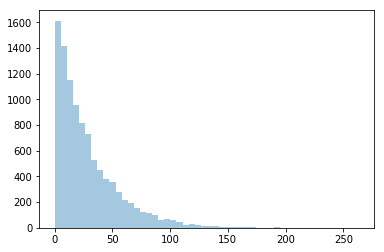

In [5]:
import seaborn as sns

sns.distplot(Exponential.dist(1/29).random(size=10000), kde=False)

In [6]:
from pymc3 import StudentT

with drug_model:
  
  drug_like = StudentT('drug_like', nu=ν, mu=μ_1, lam=σ_1**-2, observed=drug.iq)
  placebo_like = StudentT('placebo_like', nu=ν, mu=μ_0, lam=σ_0**-2, observed=placebo.iq)

<p>Modelimizi tanımladık. Şimdi, deney ve kontrol gruplarının ortalamalarındaki farkları karşılaştırabiliriz.</p>
<p>Ayrıca, etki büyüklüğünü hesaplayacağız.</p>

In [7]:
from pymc3 import Deterministic
import numpy as np

with drug_model:
  
  diff_of_means = Deterministic('difference of means', μ_1 - μ_0)
  effect_size = Deterministic('effect size', diff_of_means / np.sqrt((σ_1**2 + σ_0**2) / 2))

In [8]:
from pymc3 import fit

with drug_model:
  
  drug_trace = fit().sample(1000)

Average Loss = 244.61: 100%|██████████| 10000/10000 [00:06<00:00, 1502.21it/s]
Finished [100%]: Average Loss = 244.59


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f08d7249048>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f08d9945128>], dtype=object)

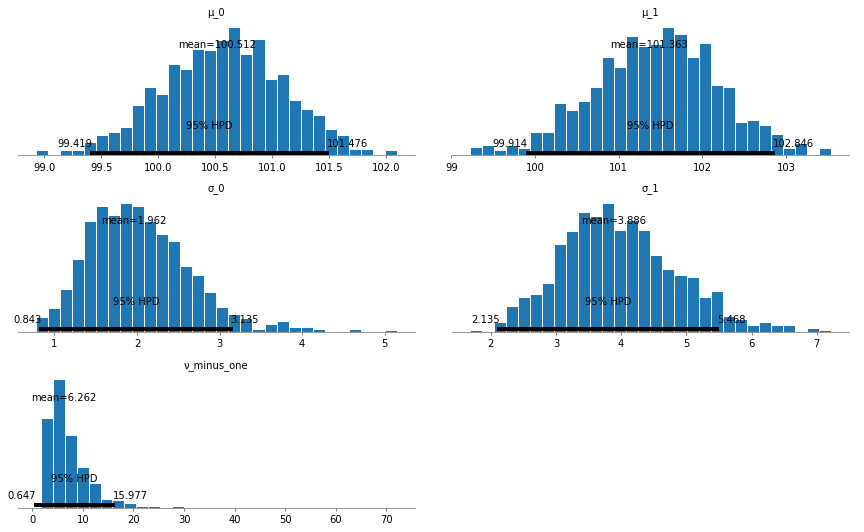

In [9]:
from pymc3 import plot_posterior

plot_posterior(drug_trace[100:], varnames=['μ_0', 'μ_1', 'σ_0', 'σ_1', 'ν_minus_one'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f08d9ec3438>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f08da0f3ba8>], dtype=object)

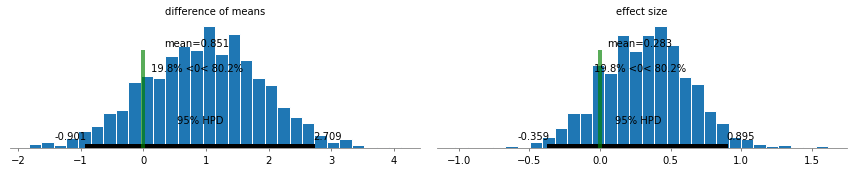

In [10]:
plot_posterior(drug_trace[100:], 
          varnames=['difference of means', 'effect size'],
          ref_val=0)

> Deney grubunun ortalama IQ skorlarının kontrol grubununu ortalama IQ skorlarından daha büyük olma sonsal olasılığı 0.802 dır.